In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp, angle, abs, unwrap, log10
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

<img src="Figurer/NTNU_Logo.png" align="left" width="30%">
<br clear="all" />
<br></br>

# Diskretisering time 2 -  *differanseligningen*

* **Emne: AIS2102 - Dynamiske system**
* ***dato***: 3. februar 2025
* **Foreleser: Kai Erik Hoff**

# Digitale regulatorer
<br>
<br>
<img src="Figurer/discrete_LTI/topic_overview.png" style="width: 70%; margin-left: 10%" />

# Tema

* Differanseligning for derivasjon
    - Implisitt Euler diskretisering av førsteordens system
* Intro til differanseligningen
    - Generell form
    - Systemkoeffisienter
    - Implementasjon
    - Analyse med Python/Matlab

# Enkelt diskretiseringseksempel
* Hvordan kan derivasjon utføres med et tidsdiskret system?
<br>
<br>
<img src="Figurer/discrete_LTI/cont_s.png" style="width: 60%; margin-left: 15%" />

# Numerisk derivasjon (bakoverdifferanse)

<br>
<br>
<img src="Figurer/discrete_LTI/backdiff.png" style="width: 70%; margin-left: 10%" />

# Implementasjon (Arduino)

* Et forslag:

---
```C++
class Differentiator{
private:
    float previousInput;
    const float timeStep;
public:
    Differentiator(float timeStep) : timeStep(timeStep), previousInput(0) {}
    float update(float newInput) {
        float output = (newInput - previousInput)/timeStep; // Utregning av derivert
        previousInput = newInput; // Oppdatering av tilstandsvariabel
        return output;
```
---

* NB! `previousInput` fungerer her som en *tilstandvariabel*

# Diskretisering av differensialligning

## Eksempel:
* Bruk tilnærmingen $\dot{y}[k] \approx \frac{y[k] - y[k-1]}{T_s}$ (implisitt Euler) til å disretisere følgende differensialligning med tidssteg $T_s = 0.125 \text{s}$:

$$ \Large \dot{y}(t) + 2\cdot y(t) = 2 \cdot u(t)$$

$$
\begin{align}
\dot{y}(t) + 2\cdot y(t) &= 2 \cdot u(t) \\
&\Downarrow \dot{y}(t) \approx \frac{y[k] - y[k-1]}{T_s} \\
\frac{y[k] - y[k-1]}{T_s} + 2\cdot y[k] &= 2 \cdot u[k] \\
\left(\frac{1}{T_s} + 2\right) y[k] - \frac{1}{T_s} y[k-1] &= 2\cdot u[k] \\
&\Downarrow T_s = 0.125 \\
10 \cdot y[k] - 8 \cdot y[k-1] &= 2 \cdot u[k]
\end{align}
$$

# Differanseligningen



* Generell form på alle tidsdisrkete LTI-system (bl.a. digitale regulatorer)

$$
\begin{align}
a_0 \cdot y[k] + a_1 \cdot y[k-1] + \ldots + a_N \cdot y[k-N] &= b_0 \cdot u[k] + b_1 \cdot u[k-1] + \ldots + b_M \cdot u[k-M]\\
\sum_{i=0}^{N} a_i \cdot y[k-i] &= \sum_{i=0}^{M} b_i \cdot u[k-i]
\end{align}
$$

- Tallrekkene $a_i$ og $b_i$ er systemets *koeffisienter*


* Antar vi at $a_0=1$, kan vi skrive definere følgende algoritme for utregning av $y[k]$:

$$y[k] = b_0 \cdot u[k] + b_1 \cdot u[k-1] + \ldots + b_M \cdot u[k-M] -  a_1 \cdot y[k-1] - \ldots - a_N \cdot y[k-N]$$

* Vi sier at systemet er *normalisert* når $a_0 = 1$

### Sammenligning av stegresponser fra eksempel


(0.0, 4.0)

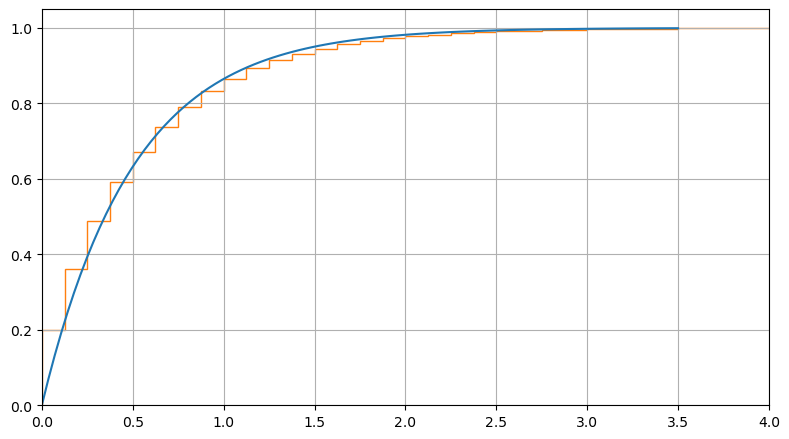

In [3]:
Ts = 0.125
sys_cont = sig.TransferFunction([2], [1, 2]) # Kontinuerlige koeffisienter
sys_disc = sig.TransferFunction([.2, 0],[1, -.8], dt=Ts) # Tidsdiskrete koeffisienter
t, y = sys_cont.step()
t_k, y_k = sys_disc.step()
y_k = y_k[0].flatten() # Scipy dstep() returnerer en tuple med kolonnevektor 
plt.plot(t, y)
plt.stairs(y_k[:-1], t_k)
plt.xlim(xmax=4)

#### I Matlab:


```Octave
Ts = 0.125

sys_disc = tf([2], [10, -8], Ts)
sys_cont = tf([2],[1, 2])

step(sys_cont)
step(sys_disc)

```

# Systemorden

* Antallet tidssteg systemet må huske målinger tilbake i tid

* For en differanseligning
$$\sum_{k=0}^{N} a_k \cdot y[n-k] = \sum_{k=0}^{M} b_k \cdot x[n-k]$$
Systemorden: $\max(N, M)$

* Ved diskretisering: <br>$N$ orden kontinuerlig system $\rightarrow$ $N$ orden diskrét system

# Blokkskjemarepresentasjon

<img src="Figurer/discrete_LTI/df1.png" style="width: 70%; margin-left: 10%" />

* Hver av blokkene merket $z^{-1}$ representerer én sample forsinkelse, og krever at kodeimplementasjonen inneholder en egen tilstandsvariabel for denne blokken.

# Mulig implementasjon

```C++
class LTI_system {
private:
    float b[];   // Feed-forward system Coefficients
    float a[];   // Feedback system coefficients
    int order;   // Total system order
    float u_i[]; // Previous Inputs u[k-i]
    float y_i[]; // Previous Outputs y[k-i]

public:
    float process_sample(float u) {
        float y = b[0] * u;  // Initialize Output y[k]

        // Add weighted sum of previous inputs/outputs
        for (int i = 1; i <= order; i++) {  
            y += b[i] * u_i[i - 1];
            y -= a[i] * y_i[i - 1];
        }

        y /= a[0];  // Divide output by a[0]. May be disregarded if a[0] = 1

        // Update state vectors
        for (int i = 1; i < order; i++) {
            u_i[i] = u_i[i - 1];
            y_i[i] = y_i[i - 1];
        }

        u_i[0] = u;
        y_i[0] = y;

        return y;
    }
};

```

* *NB! Ufullstendig kode.*

## Regneeksempel
* Normaliser det tidsdiskrete systemet $10 \cdot y[k] - 8 \cdot y[k-1] = 2 \cdot u[k]$ fra forrige eksempel, og sett opp *algoritmen* ($y[k] = \ldots$)
* Beregn så $y[k]$ for sampleintervallet $0 \leq k \leq 6$ når
$$u[k] = \begin{cases}0, & k<0 \\ 1, & k \geq 0 \end{cases}$$
    - Vi kan anta $y[k] = 0$ for $k<0$

#### Løsning:
|$$k$$|$$u[k]$$|$$y[k]$$|
|---|---|---|
|$$0$$|$$1$$|$$0.8\cdot 0 + 0.2\cdot 1 = 0.2$$|
|$$1$$|$$1$$|$$0.8\cdot 0.2 + 0.2\cdot 1 = 0.36$$|
|$$2$$|$$1$$|$$0.8\cdot 0.36 + 0.2\cdot 1 = 0.488$$|
|$$3$$|$$1$$|$$0.8\cdot 0.488 + 0.2\cdot 1 = 0.5905$$|
|$$4$$|$$1$$|$$1-0.8^5$$|
|$$5$$|$$1$$|$$1-0.8^6$$|
|$$6$$|$$1$$|$$1-0.8^7$$|
|$$k$$|$$1$$|$$1-0.8^{k+1}$$|

### Kodeillustrasjon av regneeksempel:

(0.0, 2.0)

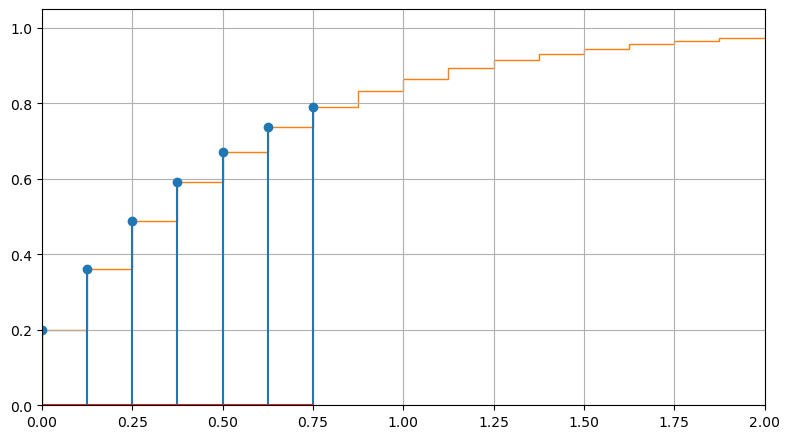

In [4]:

# "Manuell" utregning av stegrespons
y = np.zeros(7)
u = lambda k: (k>=0)*1
for k in range(7):
    y[k] = 0.2*u(k) + 0.8*y[k-1]

# Utregning med dstep()
Ts = 0.125
sys_disc = sig.TransferFunction([2, 0],[10, -8], dt=Ts) # NB!
t_k, y_k = sys_disc.step()
y_k = y_k[0].flatten() # Scipy dstep() returnerer en tuple med kolonnevektor 

# Plotting
plt.stairs(y_k[:-1], t_k, color='C1')
plt.stem(t_k[:7], y)
plt.xlim(xmax=2)

# Enkelt tidsdiskrét lavpassfilter

- Et enkelt og mye brukt førsteordens lavpassfilter:
  $$  y[k] = (1 - \alpha) \cdot u[k] + \alpha \cdot y[k - 1], \quad 0 \leq \alpha < 1  $$
  - Annet navn: «eksponentielt middelverdifilter»


# Sprangrespons for eksponentielt middelverdifilter

- Differanseligning: 
$$y[k] = (1 - \alpha) \cdot u[k] + \alpha \cdot y[k - 1]$$
  

- Generell form:
$$\begin{align}
u[k] &=
\begin{cases} 
0, & k < 0 \\ 
U, & k \geq 1 
\end{cases} \\
& \Downarrow \\
y[k] &=
\begin{cases} 
0, & k < 0 \\ 
U(1 - \alpha^{k+1}), & k \geq 0 
\end{cases}
\end{align}
$$
    - Ikke så ulikt responsen til en førsteordens differensialligning.


### Kodeillustrasjon

In [5]:
from ipywidgets import interact

@interact(alpha=0.3)
def plot_exp_step(alpha):
    # Utregning med dstep()
    sys_disc = sig.TransferFunction([(1-alpha), 0],[1, -alpha], dt=1) # NB!
    t_k, y_k = sys_disc.step()
    y_k = y_k[0].flatten() # Scipy dstep() returnerer en tuple med kolonnevektor 

    # Plotting
    plt.stairs(y_k[:-1], t_k, color='C1')
    plt.xlabel('Samplenummer $k$')
    plt.xlim(xmax=40)
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='alpha', max=0.8999999999999999, min=-0.3), Output())…

# Hva med høyereordens LTI-system?



* Vi *kan* bruke samme tilnærming med å finne en tilnærming til $\dot{u}(t)$, $\ddot{u}(t)$, $\dot{y}(t)$, $\ddot{y}(t)$ osv...
    * Tungt å utlede, og vanskelig å generalisere

* Tilstandsrom-modeller er ofte en mye enklere representasjon å diskretisere
    - Vi skal se mer på tidsdiskrete tilstandsrom-modeller, samt noen enkle diskretiserings-eksempel i neste time

# Andre Spørsmål?